two_level_system.ipynb

Perform stochastic unraveling using QuTip of a two level system interacting with a single bath at high temperature. The Hamiltonian of this system and bath with the interaction is
\begin{equation}
H = H_s + H_B + V = \frac{\Delta}{2}\sigma_z;\:\:\:\:H_s = -\frac{\Delta}{2}\sigma_z;\:\:\:\: V = S\otimes B
\end{equation}
with $B = \sum_k g_k (b_k + b_k^\dag)$ and $S = \frac{1}{\sqrt{2}}(\sigma_z + \sigma_x)$, so the interaction effectively acts on the system as a Hadamard gate.

The two levels are taken to be nearly degenerate such that $\Delta\ll ak_BT$, assuming an Ohmic spectral density $J(\omega)=a\omega$ (i.e. such that $a$ stands in the necessary relation to the $g_k$'s). In this case the full Redfield equation is of Lindblad form, provided that we can ignore the very small splitting $\Delta$ in the calculation of decay/dephasing rates. As such, there is one Lindblad or "collapse" operator, $L=S$, which is Hermitian in its own right.

Matthew Gerry, August 2023

In [2]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _utils import *

In [3]:
# Define system parameters
# N = 2 # Number of levels
Delta = 0.001 # Splitting
a = 0.02 # Dimensionless coupling constant
beta = 1

gamma = a/beta # Unlike for the V model, here we just have one rate based on the limit that the Bohr frequency vanishes

T_short = 1/(2*gamma)
T_long = 4*gamma/Delta**2
print(T_short)
print(T_long)

# Define system operators
g0 = fock(2, 0)
g1 = fock(2, 1)


H = -0.5*Delta*sigmaz() # System Hamiltonian
L = np.sqrt(gamma)*(sigmax() + sigmaz())/np.sqrt(2) # Single collapse operator

rho_ss = steadystate(H,[L])

25.0
80000.0


In [5]:
# Unravel the master equation

t0, tf = 0, 1000
dt = 0.03
tlist = np.arange(t0, tf, dt)

psi_init = g0 # Initial state
rho_init = psi_init*psi_init.dag()
e_ops = [g0*g0.dag(), g1*g1.dag(), g1*g0.dag()] # Observables
sc_ops = [L] # Stochastic collapse operators

# Collapse operators that I naively thought would apply
# sc_ops = [(g0*g0.dag() + g0*g1.dag())/np.sqrt(2), (g0*g0.dag() + g1*g0.dag())/np.sqrt(2)]

result = photocurrent_mesolve(H, rho_init, tlist, sc_ops=sc_ops, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
# result = smesolve(H, rho_init, tlist, sc_ops=sc_ops, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)


Total run time:   0.82s


In [15]:
# Get all the expectation values
g0_evo = result.expect[0]
g1_evo = result.expect[1]
g10_evo = result.expect[2]

In [18]:
# Analytic solution using the LEPE method

g10_analytic = 0.25*(np.exp(-Delta**2*tlist/(8*gamma)) - np.multiply(np.exp(-4*Delta*tlist),np.cosh(Delta*tlist/np.sqrt(2))))

(-0.01, 1.01)

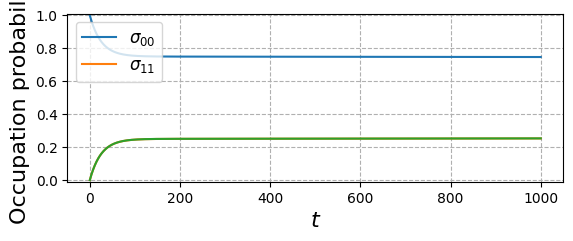

In [19]:
# Plot the populations

plt.subplot(211)
plt.plot(tlist, g0_evo, label=r'$\sigma_{00}$')
plt.plot(tlist, g1_evo, label=r'$\sigma_{11}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)


/home/mgerry/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.51, 0.51)

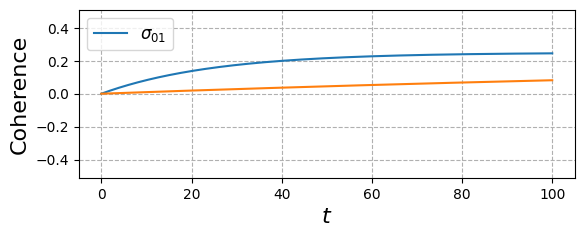

In [7]:
# Plot the coherences

plt.subplot(211)
plt.plot(tlist, g10_evo, label=r'$\sigma_{01}$')
plt.plot(tlist, g10_analytic)

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.51, 0.51)

Let's do the exact same simulation again, but this time everything in the basis where $S=L$ is diagonal ($H_S$ is not). We have $L=VL'V^{-1}$ with $L'=-\sqrt{\gamma}\sigma_z$ and $V = \frac{i}{\sqrt{2}}[[-\sqrt{1-1/\sqrt{2}}, \sqrt{1+1/\sqrt{2}}];[\frac{1}{\sqrt{2}\sqrt{1-1/\sqrt{2}}},\frac{1}{\sqrt{2}\sqrt{1+1/\sqrt{2}}}]]$.

NOTE: Using V as it is written here makes some operators non-Hermitian--need to use a version of V that is unitary. Working on it.

The system Hamiltonian in this basis becomes $H_s'=-\frac{\Delta}{2}V^{-1}\sigma_zV = \frac{\Delta}{2\sqrt{2}}(\sigma_z + \sigma_x)$.

The initial state becomes $\rho'_0 = V^{-1}|0\rangle\langle0|V = \frac{1}{2}(I-\frac{1}{\sqrt{2}}\sigma_z-\frac{1}{\sqrt{2}}\sigma_x)$

In [4]:
# Simulation in new basis

H_prime = 0.5*Delta*(sigmaz()/np.sqrt(2) + sigmax()/np.sqrt(2)) # System Hamiltonian
L_prime = -np.sqrt(gamma)*sigmaz() # Single collapse operator
rho0_prime = 0.5*(identity(2) - sigmaz()/np.sqrt(2) - sigmax()/np.sqrt(2)) # Initial state

rho_ss = steadystate(H,[L])

In [ ]:
# Unravel the master equation in this different basis
t0, tf = 0, 7500
dt = 0.04
tlist = np.arange(t0, tf, dt)

rho_init_prime = 0.5*(identity(2) - sigmaz()/np.sqrt(2) - sigmax()/np.sqrt(2))
# rho_init_prime = g0*g0.dag() # Start in a basis state
e_ops = [g0*g0.dag(), g1*g1.dag(), g1*g0.dag()] # Observables
sc_ops_prime = [L_prime] # Stochastic collapse operators
# sc_ops_prime = [-g0*g0.dag(), g1*g1.dag()] # This leads to familiar behaviour but is not physically correct

result_prime = photocurrent_mesolve(H_prime, rho_init_prime, tlist, sc_ops=sc_ops_prime, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)


KeyboardInterrupt: 

In [20]:
# Get all the expectation values
g0_evo_prime = result_prime.expect[0]
g1_evo_prime = result_prime.expect[1]
g10_evo_prime = result_prime.expect[2]

In [7]:
# Simulate a few trajectories over longer time frames to show decay of populations

tf_long = 100000
dt_long = 0.04
tlong = np.arange(t0,tf_long,dt_long)

result_long1 = photocurrent_mesolve(H_prime, rho_init_prime, tlong, sc_ops=sc_ops_prime, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
result_long2 = photocurrent_mesolve(H_prime, rho_init_prime, tlong, sc_ops=sc_ops_prime, e_ops=e_ops, ntraj=1, noise=2, store_measurement=True)
result_long3 = photocurrent_mesolve(H_prime, rho_init_prime, tlong, sc_ops=sc_ops_prime, e_ops=e_ops, ntraj=1, noise=3, store_measurement=True)

Total run time:  17.93s
Total run time:  14.54s
Total run time:  14.61s


In [8]:
# Get the state-1 population expectation values
g0_evo_long1 = result_long1.expect[0]
g0_evo_long2 = result_long2.expect[0]
g0_evo_long3 = result_long3.expect[0]

In [40]:
# Simulate a trajectory over a shorter time frame to show decay of coherece

tf_short = 250
dt_short = 0.001
tshort = np.arange(t0,tf_short,dt_short)

result_short = photocurrent_mesolve(H_prime, rho_init_prime, tshort, sc_ops=sc_ops_prime, e_ops=e_ops, ntraj=1, noise=2, store_measurement=True)

g10_evo_short = result_short.expect[2]

Total run time:   2.36s


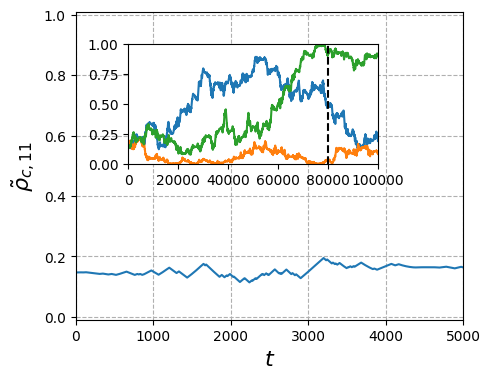

In [49]:
# Plot the populations

fig, ax1 = plt.subplots(figsize=(5,4))
# plt.plot(tlist, g0_evo_prime, label=r"$\sigma'_{00}$")
ax1.plot(tlist, g0_evo_prime)#, label=r"$\tilde{\rho}_{c,11}$") 

ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r"$\tilde{\rho}_{c,11}$", fontsize=16)
# plt.legend(fontsize=12, loc="upper left")
ax1.grid(linestyle='--')
ax1.set_xlim([t0,tf])
ax1.set_ylim(-0.01, 1.01)

ax2 = fig.add_axes([0.23,0.5,0.5,0.3])
ax2.plot(tlong,g0_evo_long1)
ax2.plot(tlong,g0_evo_long2)
ax2.plot(tlong,g0_evo_long3)
ax2.set_xlim([t0,tf_long])
ax2.set_ylim([0,1])

ax2.vlines(T_long, ymin=0, ymax=1, linestyles=['--'], colors=['k'])


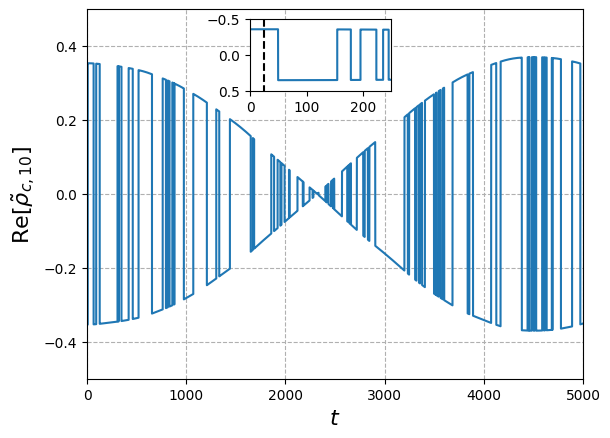

In [43]:
# Plot the coherences

fig, ax1 = plt.subplots()
ax1.plot(tlist, g10_evo_prime)#, label=r"Re[$\tilde{\rho}_{c,10}$]")

ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r"Re[$\tilde{\rho}_{c,10}$]", fontsize=16)
# ax1.legend(fontsize=12, loc="upper left")
ax1.grid(linestyle='--')
ax1.set_xlim(t0,tf)
ax1.set_ylim(-0.5, 0.5)

ax2 = fig.add_axes([0.38,0.71,0.22,0.15])
ax2.plot(tshort,g10_evo_short)
ax2.set_xlim([t0,tf_short])
ax2.set_ylim([0.5,-0.5])

ax2.vlines(T_short,-0.5, 0.5, colors=['k'], linestyles=['--'])
